In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import random
import time
from math import sqrt
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import (matthews_corrcoef, accuracy_score, confusion_matrix, 
                             roc_auc_score, average_precision_score, 
                             cohen_kappa_score, balanced_accuracy_score, 
                             roc_curve, auc, precision_recall_curve)
from bayes_opt import BayesianOptimization
from utils import (
    single_task, EarlyStopping, train_single_task, val_single_task, test_single_task,
    FocalLoss, load_data, CustomDataset)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import TensorDataset,Subset, DataLoader, Dataset as TorchDataset  # 일반적인 PyTorch의 Dataset 사용
from torch_geometric.data import InMemoryDataset, DataLoader, Batch, Dataset, Data, data
from collections import defaultdict
torch.use_deterministic_algorithms(True, warn_only=True)
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, ParameterGrid
import pandas as pd
import matplotlib.pyplot as plt  # 시각화를 위해 matplotlib도 필요합니다.
import warnings
warnings.filterwarnings("ignore")

In [3]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # 시드 고정
    torch.manual_seed(seed)  # PyTorch 난수 시드
    torch.cuda.manual_seed(seed)  # CUDA 난수 시드
    torch.cuda.manual_seed_all(seed)  # 멀티 GPU 사용 시 시드 고정
    
    # CuDNN을 결정적 모드로 설정
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Numpy 및 파이썬 기본 random 모듈의 시드 고정
    np.random.seed(seed)
    random.seed(seed)
    

# 시드 고정 호출
set_seed(0)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
rng = np.random.default_rng(8888)
rfloat = rng.random()

In [4]:
def evaluate_model(model, device, data_loader):
    model.eval()
    y_true = []
    y_scores = []
    
    with torch.no_grad():
        for batch in data_loader:
            data = batch.to(device)
            labels = batch.y.to(device)
            outputs, _ = model(data)
            outputs = outputs.view_as(labels)
            probs = torch.sigmoid(outputs).cpu().numpy()
            y_scores.extend(probs.flatten())
            y_true.extend(labels.cpu().numpy().flatten())
    
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # -1 라벨 제거
    mask = y_true != -1
    y_true = y_true[mask]
    y_scores = y_scores[mask]
    
    try:
        auc = roc_auc_score(y_true, y_scores)
    except ValueError:
        auc = np.nan  # AUC를 계산할 수 없는 경우

    try:
        pr_auc = average_precision_score(y_true, y_scores)
    except ValueError:
        pr_auc = np.nan  # PR AUC를 계산할 수 없는 경우

    y_pred_labels = (y_scores >= 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_labels)
    
    return auc, pr_auc, accuracy

Total hyperparameter combinations to evaluate: 12

===== Evaluating Hyperparameter Combination 1/12 =====
Parameters: {'batch_size': 8, 'dropout': 0.2, 'lr': 0.001, 'output_dim': 8, 'wd': 1e-06}

--- Fold 1/20 ---
Early stopping triggered at epoch 46. Best Val Loss: 0.0119
====> Epoch: 46 Average test Loss: 0.0128
Fold 1 Results - Best Epoch: 46, Val Loss: 0.0119, Test Loss: 0.0128, Test AUC: 0.8250, PR AUC: 0.8740, Accuracy: 0.5556

--- Fold 2/20 ---
Early stopping triggered at epoch 38. Best Val Loss: 0.0097
====> Epoch: 38 Average test Loss: 0.0107
Fold 2 Results - Best Epoch: 38, Val Loss: 0.0097, Test Loss: 0.0107, Test AUC: 0.8750, PR AUC: 0.9207, Accuracy: 0.5556

--- Fold 3/20 ---
Early stopping triggered at epoch 40. Best Val Loss: 0.0111
====> Epoch: 40 Average test Loss: 0.0131
Fold 3 Results - Best Epoch: 40, Val Loss: 0.0111, Test Loss: 0.0131, Test AUC: 0.8000, PR AUC: 0.8689, Accuracy: 0.5556

--- Fold 4/20 ---
Early stopping triggered at epoch 49. Best Val Loss: 0.0118


Early stopping triggered at epoch 46. Best Val Loss: 0.0108
====> Epoch: 46 Average test Loss: 0.0131
Fold 13 Results - Best Epoch: 46, Val Loss: 0.0108, Test Loss: 0.0131, Test AUC: 0.7639, PR AUC: 0.8282, Accuracy: 0.5294

--- Fold 14/20 ---
Early stopping triggered at epoch 39. Best Val Loss: 0.0142
====> Epoch: 39 Average test Loss: 0.0100
Fold 14 Results - Best Epoch: 39, Val Loss: 0.0142, Test Loss: 0.0100, Test AUC: 0.8889, PR AUC: 0.9017, Accuracy: 0.5294

--- Fold 15/20 ---
Early stopping triggered at epoch 22. Best Val Loss: 0.0146
====> Epoch: 22 Average test Loss: 0.0159
Fold 15 Results - Best Epoch: 22, Val Loss: 0.0146, Test Loss: 0.0159, Test AUC: 0.7778, PR AUC: 0.7720, Accuracy: 0.5294

--- Fold 16/20 ---
Early stopping triggered at epoch 44. Best Val Loss: 0.0141
====> Epoch: 44 Average test Loss: 0.0169
Fold 16 Results - Best Epoch: 44, Val Loss: 0.0141, Test Loss: 0.0169, Test AUC: 0.8472, PR AUC: 0.8497, Accuracy: 0.5294

--- Fold 17/20 ---
Early stopping triggered

Early stopping triggered at epoch 51. Best Val Loss: 0.0095
====> Epoch: 51 Average test Loss: 0.0105
Fold 5 Results - Best Epoch: 51, Val Loss: 0.0095, Test Loss: 0.0105, Test AUC: 0.8714, PR AUC: 0.9285, Accuracy: 0.5882

--- Fold 6/20 ---
Early stopping triggered at epoch 65. Best Val Loss: 0.0069
====> Epoch: 65 Average test Loss: 0.0119
Fold 6 Results - Best Epoch: 65, Val Loss: 0.0069, Test Loss: 0.0119, Test AUC: 0.9000, PR AUC: 0.9327, Accuracy: 0.5882

--- Fold 7/20 ---
Early stopping triggered at epoch 50. Best Val Loss: 0.0128
====> Epoch: 50 Average test Loss: 0.0217
Fold 7 Results - Best Epoch: 50, Val Loss: 0.0128, Test Loss: 0.0217, Test AUC: 0.8333, PR AUC: 0.8083, Accuracy: 0.5294

--- Fold 8/20 ---
Early stopping triggered at epoch 28. Best Val Loss: 0.0126
====> Epoch: 28 Average test Loss: 0.0185
Fold 8 Results - Best Epoch: 28, Val Loss: 0.0126, Test Loss: 0.0185, Test AUC: 0.5833, PR AUC: 0.6822, Accuracy: 0.5294

--- Fold 9/20 ---
Early stopping triggered at epoc

Early stopping triggered at epoch 27. Best Val Loss: 0.0144
====> Epoch: 27 Average test Loss: 0.0111
Fold 18 Results - Best Epoch: 27, Val Loss: 0.0144, Test Loss: 0.0111, Test AUC: 0.8333, PR AUC: 0.8520, Accuracy: 0.5294

--- Fold 19/20 ---
Early stopping triggered at epoch 46. Best Val Loss: 0.0127
====> Epoch: 46 Average test Loss: 0.0295
Fold 19 Results - Best Epoch: 46, Val Loss: 0.0127, Test Loss: 0.0295, Test AUC: 0.6250, PR AUC: 0.7395, Accuracy: 0.5294

--- Fold 20/20 ---
Early stopping triggered at epoch 28. Best Val Loss: 0.0113
====> Epoch: 28 Average test Loss: 0.0353
Fold 20 Results - Best Epoch: 28, Val Loss: 0.0113, Test Loss: 0.0353, Test AUC: 0.8472, PR AUC: 0.8366, Accuracy: 0.5294

Combination 5 Results:
Mean Test Loss: 0.0160 ± 0.0066
Mean Test AUC: 0.8001 ± 0.0920
Mean Test PR AUC: 0.8403 ± 0.0739
Mean Test Accuracy: 0.5422 ± 0.0214

===== Evaluating Hyperparameter Combination 6/12 =====
Parameters: {'batch_size': 8, 'dropout': 0.2, 'lr': 0.001, 'output_dim': 16

Early stopping triggered at epoch 18. Best Val Loss: 0.0171
====> Epoch: 18 Average test Loss: 0.0196
Fold 10 Results - Best Epoch: 18, Val Loss: 0.0171, Test Loss: 0.0196, Test AUC: 0.5556, PR AUC: 0.5756, Accuracy: 0.5294

--- Fold 11/20 ---
Early stopping triggered at epoch 124. Best Val Loss: 0.0141
====> Epoch: 124 Average test Loss: 0.0113
Fold 11 Results - Best Epoch: 124, Val Loss: 0.0141, Test Loss: 0.0113, Test AUC: 0.9028, PR AUC: 0.9202, Accuracy: 0.5294

--- Fold 12/20 ---
Early stopping triggered at epoch 90. Best Val Loss: 0.0148
====> Epoch: 90 Average test Loss: 0.0109
Fold 12 Results - Best Epoch: 90, Val Loss: 0.0148, Test Loss: 0.0109, Test AUC: 0.9306, PR AUC: 0.9460, Accuracy: 0.5294

--- Fold 13/20 ---
Early stopping triggered at epoch 164. Best Val Loss: 0.0116
====> Epoch: 164 Average test Loss: 0.0117
Fold 13 Results - Best Epoch: 164, Val Loss: 0.0116, Test Loss: 0.0117, Test AUC: 0.8194, PR AUC: 0.9050, Accuracy: 0.5294

--- Fold 14/20 ---
Early stopping tri

Early stopping triggered at epoch 109. Best Val Loss: 0.0130
====> Epoch: 109 Average test Loss: 0.0148
Fold 1 Results - Best Epoch: 109, Val Loss: 0.0130, Test Loss: 0.0148, Test AUC: 0.7125, PR AUC: 0.7889, Accuracy: 0.5556

--- Fold 2/20 ---
Early stopping triggered at epoch 11. Best Val Loss: 0.0180
====> Epoch: 11 Average test Loss: 0.0190
Fold 2 Results - Best Epoch: 11, Val Loss: 0.0180, Test Loss: 0.0190, Test AUC: 0.6375, PR AUC: 0.7152, Accuracy: 0.5556

--- Fold 3/20 ---
Early stopping triggered at epoch 11. Best Val Loss: 0.0182
====> Epoch: 11 Average test Loss: 0.0191
Fold 3 Results - Best Epoch: 11, Val Loss: 0.0182, Test Loss: 0.0191, Test AUC: 0.6375, PR AUC: 0.7538, Accuracy: 0.5556

--- Fold 4/20 ---
Early stopping triggered at epoch 123. Best Val Loss: 0.0141
====> Epoch: 123 Average test Loss: 0.0136
Fold 4 Results - Best Epoch: 123, Val Loss: 0.0141, Test Loss: 0.0136, Test AUC: 0.7429, PR AUC: 0.7769, Accuracy: 0.5882

--- Fold 5/20 ---
Early stopping triggered a

Early stopping triggered at epoch 91. Best Val Loss: 0.0158
====> Epoch: 91 Average test Loss: 0.0144
Fold 14 Results - Best Epoch: 91, Val Loss: 0.0158, Test Loss: 0.0144, Test AUC: 0.7917, PR AUC: 0.7723, Accuracy: 0.5294

--- Fold 15/20 ---
Early stopping triggered at epoch 18. Best Val Loss: 0.0181
====> Epoch: 18 Average test Loss: 0.0187
Fold 15 Results - Best Epoch: 18, Val Loss: 0.0181, Test Loss: 0.0187, Test AUC: 0.4583, PR AUC: 0.6173, Accuracy: 0.5294

--- Fold 16/20 ---
Early stopping triggered at epoch 11. Best Val Loss: 0.0181
====> Epoch: 11 Average test Loss: 0.0194
Fold 16 Results - Best Epoch: 11, Val Loss: 0.0181, Test Loss: 0.0194, Test AUC: 0.8056, PR AUC: 0.8693, Accuracy: 0.5294

--- Fold 17/20 ---
Early stopping triggered at epoch 13. Best Val Loss: 0.0184
====> Epoch: 13 Average test Loss: 0.0205
Fold 17 Results - Best Epoch: 13, Val Loss: 0.0184, Test Loss: 0.0205, Test AUC: 0.4306, PR AUC: 0.6060, Accuracy: 0.5294

--- Fold 18/20 ---
Early stopping triggered

Early stopping triggered at epoch 22. Best Val Loss: 0.0173
====> Epoch: 22 Average test Loss: 0.0189
Fold 5 Results - Best Epoch: 22, Val Loss: 0.0173, Test Loss: 0.0189, Test AUC: 0.5143, PR AUC: 0.6294, Accuracy: 0.5882

--- Fold 6/20 ---
Early stopping triggered at epoch 221. Best Val Loss: 0.0065
====> Epoch: 221 Average test Loss: 0.0159
Fold 6 Results - Best Epoch: 221, Val Loss: 0.0065, Test Loss: 0.0159, Test AUC: 0.7857, PR AUC: 0.8802, Accuracy: 0.5882

--- Fold 7/20 ---
Early stopping triggered at epoch 140. Best Val Loss: 0.0138
====> Epoch: 140 Average test Loss: 0.0163
Fold 7 Results - Best Epoch: 140, Val Loss: 0.0138, Test Loss: 0.0163, Test AUC: 0.8056, PR AUC: 0.7856, Accuracy: 0.5294

--- Fold 8/20 ---
Early stopping triggered at epoch 22. Best Val Loss: 0.0179
====> Epoch: 22 Average test Loss: 0.0193
Fold 8 Results - Best Epoch: 22, Val Loss: 0.0179, Test Loss: 0.0193, Test AUC: 0.4167, PR AUC: 0.5644, Accuracy: 0.5294

--- Fold 9/20 ---
Early stopping triggered a

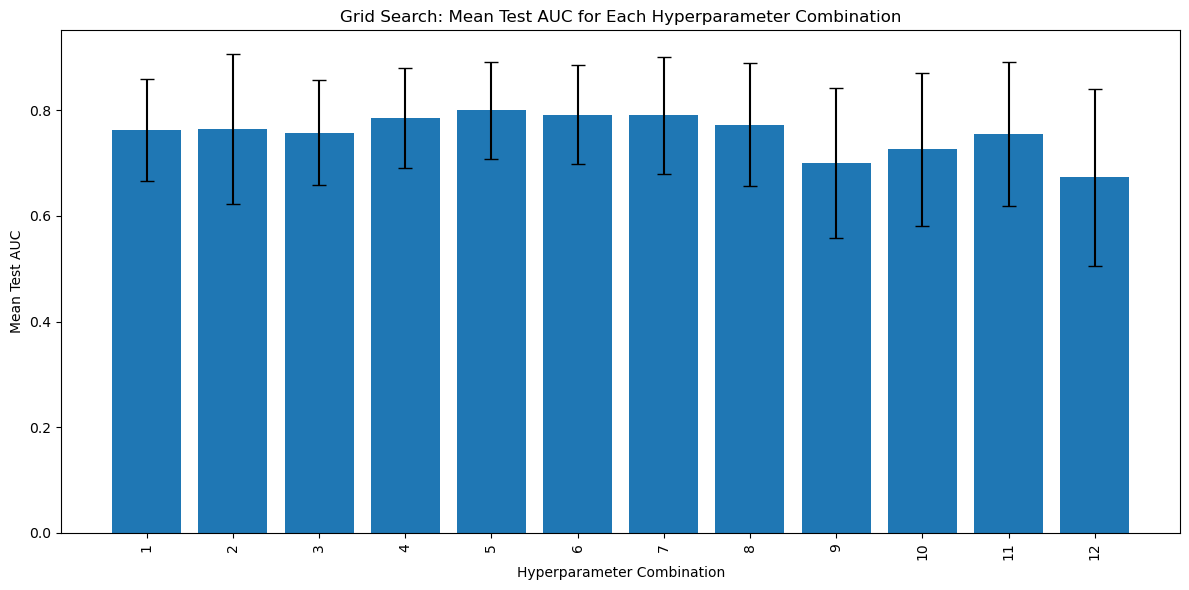

In [5]:
def main():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    K = 20  # Number of folds
    
    # Define the hyperparameter grid
    param_grid = {
        'output_dim': [8, 16],
        'dropout': [0.2],
        'batch_size': [8],
        'lr': [0.001, 0.0001],
        'wd': [1e-06, 1e-05, 1e-04],
    }
    
    grid = list(ParameterGrid(param_grid))
    total_combinations = len(grid)
    print(f"Total hyperparameter combinations to evaluate: {total_combinations}")
    
    # Load the dataset once
    dataset = load_data("sto")
    X = dataset.data_x
    y = dataset.data_y
    
    # Initialize K-Fold
    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=2)
    
    # Prepare to store all results
    all_results = []
    
    # Iterate over each hyperparameter combination
    for idx, params in enumerate(grid, 1):
        print(f"\n===== Evaluating Hyperparameter Combination {idx}/{total_combinations} =====")
        print(f"Parameters: {params}")
        
        # To store results for all folds for the current hyperparameter combination
        fold_results = []
        
        for fold, (train_indices, test_indices) in enumerate(kf.split(X, y), 1):
            print(f"\n--- Fold {fold}/{K} ---")
            
            # Stratified Shuffle Split for validation set
            sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=1)
            train_idx, val_idx = next(sss.split(np.zeros(len(train_indices)), y[train_indices]))
            
            # Subset datasets
            train_subset = Subset(dataset, train_indices[train_idx])
            val_subset = Subset(dataset, train_indices[val_idx])
            test_subset = Subset(dataset, test_indices)
            
            # DataLoaders
            batch_size = params['batch_size']
            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=Batch.from_data_list)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=Batch.from_data_list)
            test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, collate_fn=Batch.from_data_list)
            
            # Initialize the model with current hyperparameters
            model = single_task(
                num_features=75, 
                n_heads1=2, 
                output_dim=params['output_dim'],
                dropout=params['dropout']
            ).to(device)
            
            # Define Loss and Optimizer with current hyperparameters
            criterion = FocalLoss(alpha=0.25, gamma=4.0, reduction='mean')
            optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['wd'])
            
            # EarlyStopping setup
            checkpoint_path = f'/data/home/dbswn0814/2025JCM/model/single task/sto/weight/checkpoint_combination_{idx}_fold_{fold}.pt'
            early_stopping = EarlyStopping(patience=10, verbose=False, path=checkpoint_path, trace_func=lambda x: None)
            
            # Training Loop
            num_epochs = 1000
            best_epoch = 0
            for epoch in range(1, num_epochs + 1):
                train_loss = train_single_task(epoch, model, criterion, optimizer, device, train_loader)
                val_loss = val_single_task(epoch, model, criterion, device, val_loader)
    
#                 print(f"Epoch {epoch}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
                # Early Stopping
                early_stopping(val_loss, model)
    
                if early_stopping.early_stop:
                    print(f"Early stopping triggered at epoch {epoch}. Best Val Loss: {early_stopping.val_loss_min:.4f}")
                    best_epoch = epoch
                    break
                best_epoch = epoch  # Update best epoch
    
            # Load the best model
            model.load_state_dict(torch.load(checkpoint_path))
            
            # Evaluate on Test Set
            test_loss = test_single_task(epoch, model, criterion, device, test_loader)
            test_auc, test_pr_auc, test_accuracy = evaluate_model(model, device, test_loader)
            
            print(f"Fold {fold} Results - Best Epoch: {best_epoch}, Val Loss: {early_stopping.val_loss_min:.4f}, Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}, PR AUC: {test_pr_auc:.4f}, Accuracy: {test_accuracy:.4f}")
            
            # Store fold results
            fold_result = {
                'Combination': idx,
                'Fold': fold,
                'Best_Epoch': best_epoch,
                'Best_Val_Loss': early_stopping.val_loss_min,
                'Test_Loss': test_loss,
                'Test_AUC': test_auc,
                'Test_PR_AUC': test_pr_auc,
                'Test_Accuracy': test_accuracy
            }
            fold_results.append(fold_result)
        
        # After all folds, compute average and std metrics
        test_losses = [fr['Test_Loss'] for fr in fold_results]
        test_aucs = [fr['Test_AUC'] for fr in fold_results]
        test_pr_aucs = [fr['Test_PR_AUC'] for fr in fold_results]
        test_accuracies = [fr['Test_Accuracy'] for fr in fold_results]
        
        mean_test_loss = np.mean(test_losses)
        std_test_loss = np.std(test_losses)
        mean_test_auc = np.mean(test_aucs)
        std_test_auc = np.std(test_aucs)
        mean_test_pr_auc = np.mean(test_pr_aucs)
        std_test_pr_auc = np.std(test_pr_aucs)
        mean_test_accuracy = np.mean(test_accuracies)
        std_test_accuracy = np.std(test_accuracies)
        
        # Append the overall results for the current combination
        combination_result = {
            'Combination': idx,
            **params,
            'Mean_Test_Loss': mean_test_loss,
            'Std_Test_Loss': std_test_loss,
            'Mean_Test_AUC': mean_test_auc,
            'Std_Test_AUC': std_test_auc,
            'Mean_Test_PR_AUC': mean_test_pr_auc,
            'Std_Test_PR_AUC': std_test_pr_auc,
            'Mean_Test_Accuracy': mean_test_accuracy,
            'Std_Test_Accuracy': std_test_accuracy
        }
        all_results.append(combination_result)
        
        # Optionally, print the results for the current combination
        print(f"\nCombination {idx} Results:")
        print(f"Mean Test Loss: {mean_test_loss:.4f} ± {std_test_loss:.4f}")
        print(f"Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}")
        print(f"Mean Test PR AUC: {mean_test_pr_auc:.4f} ± {std_test_pr_auc:.4f}")
        print(f"Mean Test Accuracy: {mean_test_accuracy:.4f} ± {std_test_accuracy:.4f}")
    
    # After all combinations, save results to CSV
    results_df = pd.DataFrame(all_results)
    results_csv_path = 'single sto grid_search_results.csv'
    results_df.to_csv(results_csv_path, index=False)
    print(f"\nGrid search completed. Results saved to {results_csv_path}")
    
    # Optionally, visualize the results
    # Example: Plot Mean Test AUC for each combination
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(all_results)), results_df['Mean_Test_AUC'], yerr=results_df['Std_Test_AUC'], capsize=5)
    plt.xlabel('Hyperparameter Combination')
    plt.ylabel('Mean Test AUC')
    plt.title('Grid Search: Mean Test AUC for Each Hyperparameter Combination')
    plt.xticks(range(len(all_results)), results_df['Combination'], rotation=90)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()